In [17]:
import numpy as np
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from itertools import product

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [18]:
# Load datasets
sp500_train = pd.read_csv('Datasets/sp500_train.csv', index_col='Date', parse_dates=True)
sp500_test = pd.read_csv('Datasets/sp500_test.csv', index_col='Date', parse_dates=True)
tesla_train = pd.read_csv('Datasets/tesla_train.csv', index_col='Date', parse_dates=True)
tesla_test = pd.read_csv('Datasets/tesla_test.csv', index_col='Date', parse_dates=True)

In [19]:
# Check for missing values
print("Missing values in sp500_train:", sp500_train.isnull().sum().sum())
print("Missing values in sp500_test:", sp500_test.isnull().sum().sum())
print("Missing values in tesla_train:", tesla_train.isnull().sum().sum())
print("Missing values in tesla_test:", tesla_test.isnull().sum().sum())


Missing values in sp500_train: 0
Missing values in sp500_test: 0
Missing values in tesla_train: 0
Missing values in tesla_test: 0


In [20]:
#Stationarity test for SP500
from statsmodels.tsa.stattools import adfuller
results = adfuller(sp500_train['Close'])
print('ADF Statistic:', results[0])
print('p-value:', results[1])


ADF Statistic: -0.4183723892958118
p-value: 0.9069857580619163


1
ADF Statistic: -14.83671639037054
p-value: 1.863559259215005e-27


Text(0, 0.5, 'ACF')

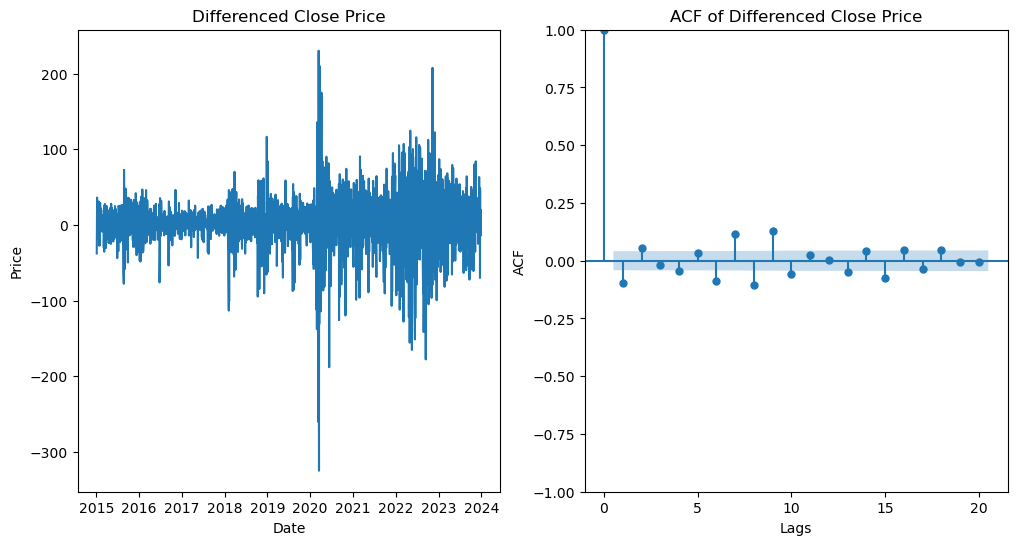

In [21]:
# Differecing since data in not stationary based on ADF test

# Checking the number of differences needed to make the series stationary
from pmdarima.arima.utils import ndiffs
print(ndiffs(sp500_train['Close']))

sp500_diff = sp500_train.diff().dropna()

results = adfuller(sp500_diff)
print('ADF Statistic:', results[0])
print('p-value:', results[1])

# Plot the differenced data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
ax1.plot(sp500_diff, label='Differenced Close Price')
ax1.set_title('Differenced Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Plot ACF of the differenced data, show correcaltion of current values with past values - helps determine MA order
plot_acf(sp500_diff, lags=20, ax=ax2)
ax2.set_title('ACF of Differenced Close Price')
ax2.set_xlabel('Lags')
ax2.set_ylabel('ACF')


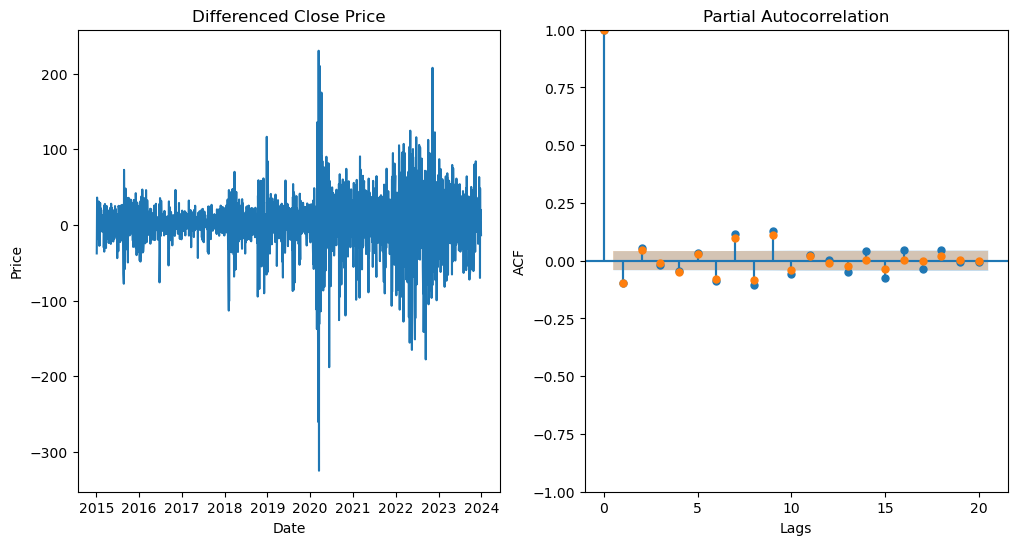

In [22]:
# Plot PACF of the differenced data, show partial correlation of current values with past values - helps determine AR order - direct correlation
plot_pacf(sp500_diff, lags=20, ax=ax2)

In [31]:
p_values = range(0, 11)
q_values = range(0, 11)
d_values = range(1, 3) 

# Function to evaluate best p,d,q for ARIMA model
def evaluate_arima_model(train, test, arima_order):
    try:        
        # Fit ARIMA model
        model = ARIMA(train, order=arima_order)
        model_fit = model.fit()
        predictions = model_fit.forecast(steps=len(test))
        
        #Compute RMSE, MAE, MAPE
        rmse = np.sqrt(mean_squared_error(test, predictions))
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        #zs = zscore(test - predictions)
        return rmse, mae, mape, model_fit, predictions
    except Exception as e:
        print(f"Error for ARIMA order {arima_order}: {e}")  # Print the error message
        return None, None, None, None, None
    
# Print the best results for each combination of p, d, q based on RMSE, MAE, and MAPE
def getBestResults(train, test):
    results = []
    for p,q,d in product(p_values, q_values, d_values):
        arima_order = (p, d, q)
        rmse, mae, mape, model_fit, predictions = evaluate_arima_model(train, test, arima_order)
        results.append((arima_order, rmse, mae, mape, model_fit))
        
    results = [result for result in results if result[1] is not None and result[2] is not None and result[3] is not None]
    best_model_rmse = min(results, key=lambda x: x[1])
    best_model_mae = min (results, key=lambda x: x[2])
    best_model_mape = min(results, key = lambda x: x[3])
    print(f"Best model RMSE is {best_model_rmse[0]} with RMSE: {best_model_rmse[1]}")
    print(f"Best model MAE is {best_model_mae[0]} with MAE: {best_model_mae[2]}")
    print(f"Best model MAPE is {best_model_mape[0]} with MAPE: {best_model_mape[3]}")
    
    
   
getBestResults(sp500_train['Close'], sp500_test['Close'])


Best model RMSE is (10, 2, 0) with RMSE: 273.3501530667711
Best model MAE is (1, 2, 10) with MAE: 229.92645570259882
Best model MAPE is (1, 2, 10) with MAPE: 0.04111737405059569


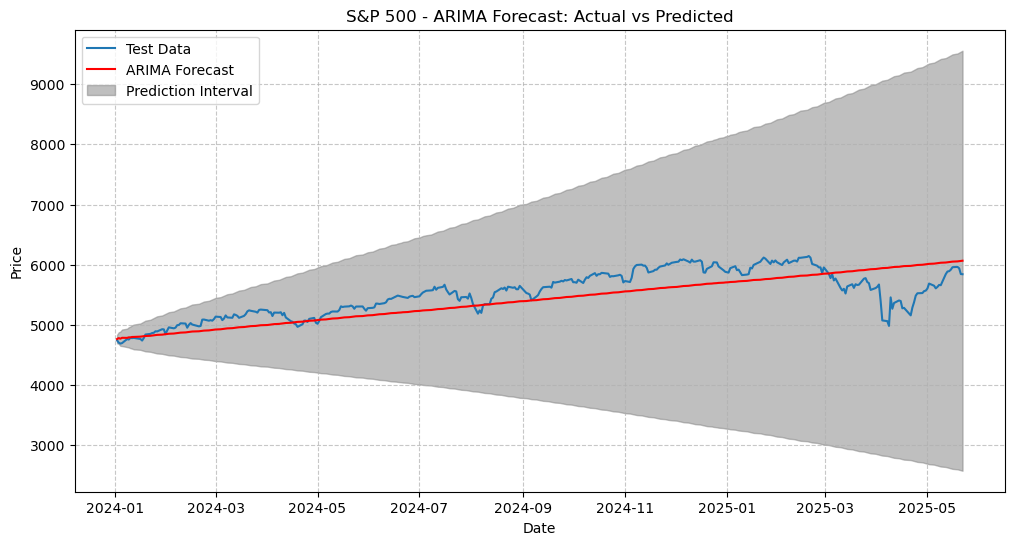

In [ ]:
#ARIMA model
# Fit the ARIMA model with the best order found
sp500_model = ARIMA(sp500_train, order=(1, 2, 10))
sp500_model_fit = sp500_model.fit()

steps_sp500 = len(sp500_test)
sp500_forecast_fit = sp500_model_fit.get_forecast(steps=steps_sp500)
arima_pred_sp500 = sp500_forecast_fit.predicted_mean
arima_pred_sp500.index = sp500_test.index
arima_conf_sp500 = sp500_forecast_fit.conf_int(alpha=0.05)
arima_conf_sp500.index = sp500_test.index

plt.figure(figsize=(12, 6))
plt.title('S&P 500 - ARIMA Forecast: Actual vs Predicted')
plt.plot(sp500_test['Close'], label='Test Data')
plt.plot(arima_pred_sp500, label='ARIMA Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.grid(which='major', axis='both', linestyle='--', alpha=0.7)
plt.fill_between(
    arima_pred_sp500.index,
    arima_conf_sp500.iloc[:, 0],  # lower bound
    arima_conf_sp500.iloc[:, 1],  # upper bound
    color='gray', alpha=0.5, label='Prediction Interval',
)
plt.legend()
plt.show()



SP500 ARIMA Model - RMSE: 273.5833136876919, MAE: 229.92645570259882, MAPE: 0.04111737405059569


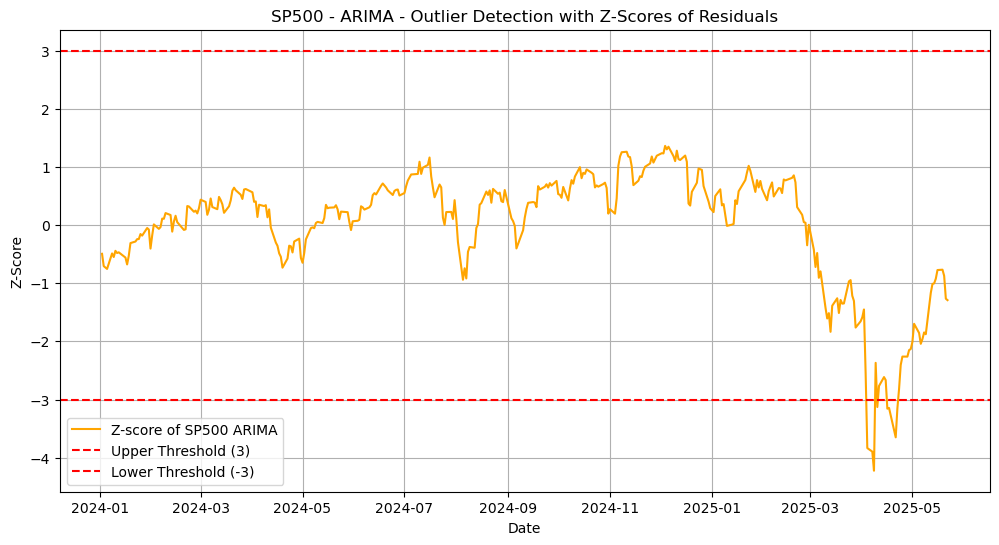

In [ ]:
#MSE, MAE, MAPE and Z-Score for SP500 ARIMA model
mse_sp500 = mean_squared_error(sp500_test['Close'], arima_pred_sp500)
rmse_sp500 = np.sqrt(mse_sp500)
mae_sp500 = mean_absolute_error(sp500_test['Close'], arima_pred_sp500)
mape_sp500 = mean_absolute_percentage_error(sp500_test['Close'], arima_pred_sp500)
mape_sp500_percent = mape_sp500 * 100

zscore_sp500 = zscore(sp500_test['Close'] - arima_pred_sp500)
print(f"SP500 ARIMA Model - RMSE: {rmse_sp500}, MAE: {mae_sp500}, MAPE: {mape_sp500}")

plt.figure(figsize=(12,6))
plt.plot(arima_pred_sp500.index, zscore_sp500, label = 'Z-score of SP500 ARIMA', color = 'orange')
plt.axhline(y=3, color='r', linestyle='--', label='Upper Threshold (3)')
plt.axhline(y=-3, color='r', linestyle='--', label='Lower Threshold (-3)')
plt.title('SP500 - ARIMA - Outlier Detection with Z-Scores of Residuals')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Modeling ARIMA for Tesla
#stationarity test for Tesla
resulsts_tesla = adfuller(tesla_train['Close'])
print('ADF Statistic for Tesla:', resulsts_tesla[0])
print('p-value for Tesla:', resulsts_tesla[1])

ADF Statistic for Tesla: -1.0815709783181922
p-value for Tesla: 0.7223649564823023


Text(0, 0.5, 'ACF')

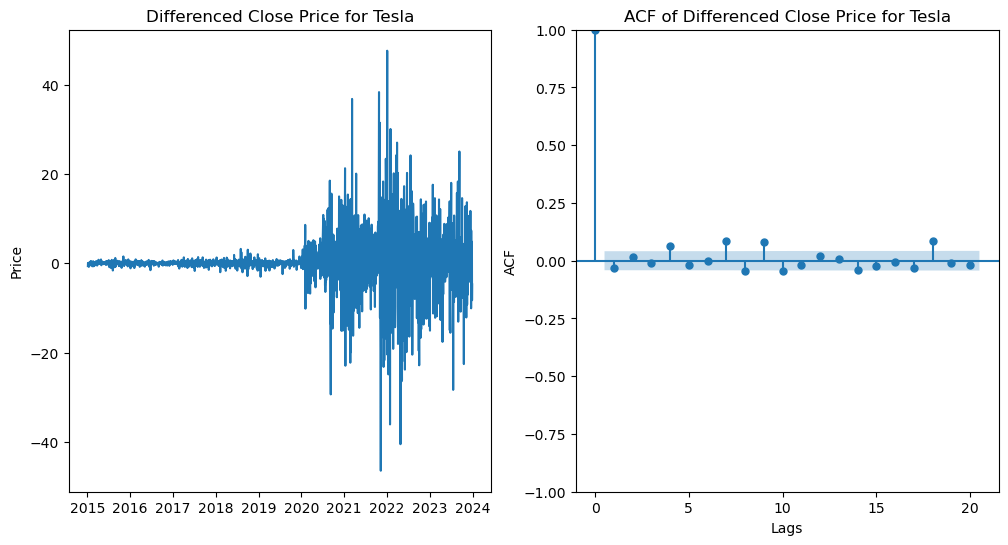

In [ ]:
telsa_train_diff  = tesla_train.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1,2 , figsize=(12,6))
ax1.plot(telsa_train_diff['Close'], label ='Differenced Close Price')
ax1.set_title('Differenced Close Price for Tesla')
ax1.set_label('Date')
ax1.set_ylabel('Price')

# Plot ACF
plot_acf(telsa_train_diff, lags=20, ax=ax2)
ax2.set_title('ACF of Differenced Close Price for Tesla')
ax2.set_xlabel('Lags')
ax2.set_ylabel('ACF')

Text(0, 0.5, 'PACF')

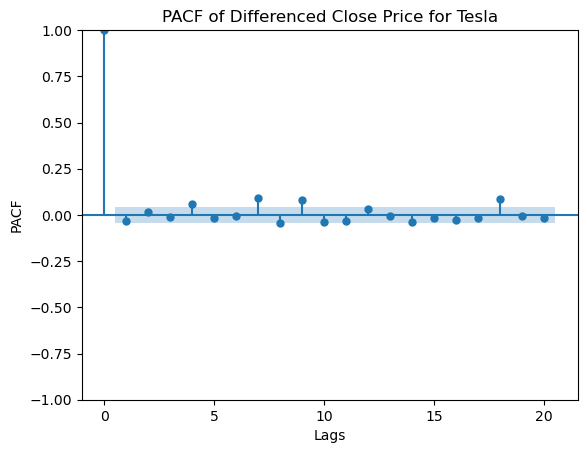

In [ ]:
#Plot PACF
plot_pacf(telsa_train_diff, lags = 20)
plt.title('PACF of Differenced Close Price for Tesla')
plt.xlabel('Lags')
plt.ylabel('PACF')


In [ ]:
# Calculate the best p, d, q values for Tesla
getBestResults(tesla_train['Close'], tesla_test['Close'])

Best model RMSE is (9, 2, 8) with RMSE: 71.97772261595999
Best model MAE is (7, 2, 6) with MAE: 59.35049430613335
Best model MAPE is (6, 1, 4) with MAPE: 0.237467987382078


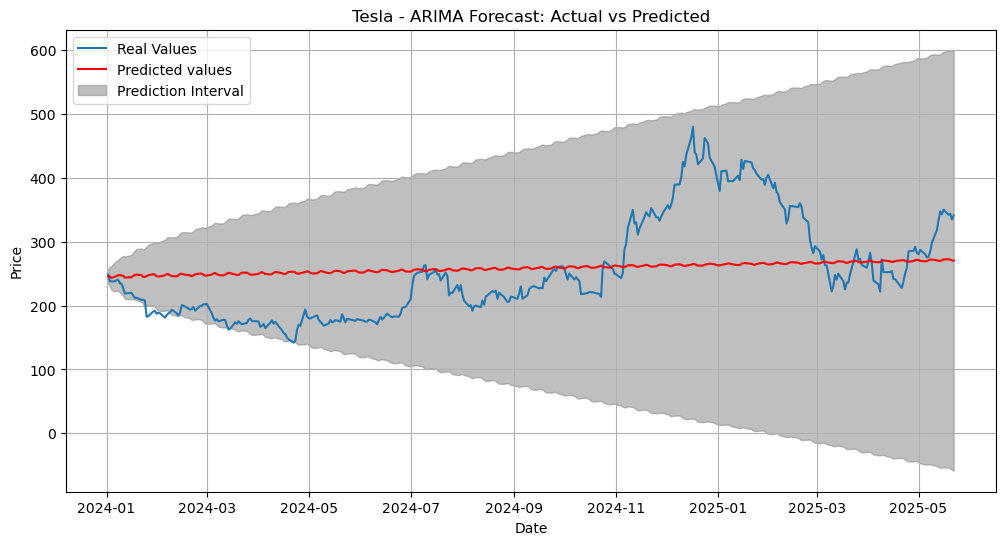

In [ ]:
# Create an ARIMA model for Tesla using the best orders
tesla_model = ARIMA(tesla_train['Close'], order = (7,2,6))
tesla_model_fit = tesla_model.fit()

steps_tesla = len(tesla_test)
forecast_tesla_fit = tesla_model_fit.get_forecast(steps=steps_tesla)
arima_prediction_tesla = forecast_tesla_fit.predicted_mean
arima_prediction_tesla.index = tesla_test.index
arima_prediction_tesla_conf = forecast_tesla_fit.conf_int(alpha = 0.05)

plt.figure(figsize=(12, 6))
plt.plot(tesla_test['Close'], label = 'Real Values')
plt.plot(arima_prediction_tesla, label = 'Predicted values', color = 'r')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tesla - ARIMA Forecast: Actual vs Predicted')
plt.fill_between(
    arima_prediction_tesla.index,
    arima_prediction_tesla_conf.iloc[:,0],
    arima_prediction_tesla_conf.iloc[:,1],
    color='gray', alpha=0.5, label='Prediction Interval'
)
plt.legend()
plt.show()

RMSE = 73.2801648882834, MAE = 59.35049430613335, MAPE = 0.24230689792375107


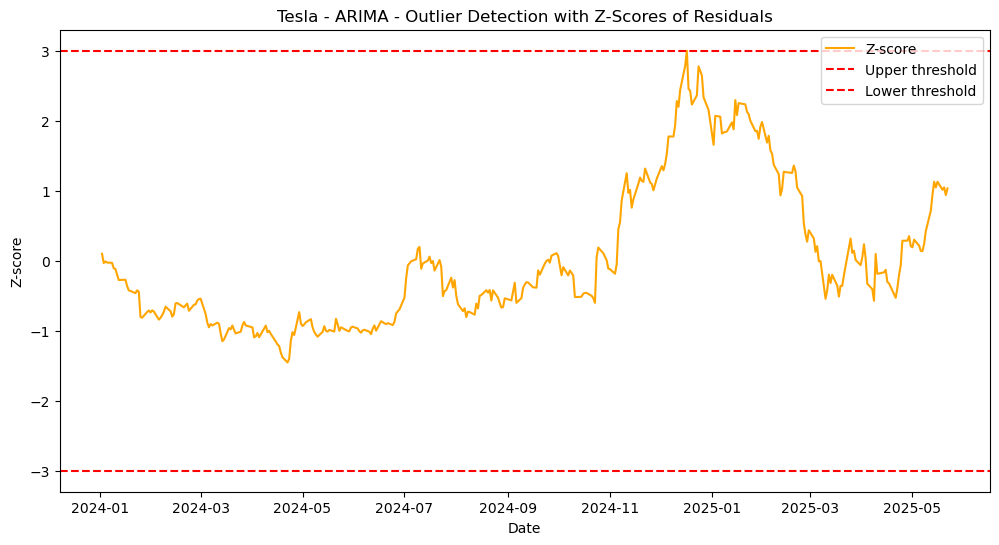

In [ ]:
#Calcuate MSE, MAE, MAPE and Z-score for Tesla ARIMA model
mse_tesla = mean_squared_error(tesla_test['Close'], arima_prediction_tesla)
rmse_tesla = np.sqrt(mse_tesla)
mae_tesla = mean_absolute_error(tesla_test['Close'], arima_prediction_tesla)
mape_tesla = mean_absolute_percentage_error(tesla_test['Close'], arima_prediction_tesla)
mape_tesla_percent = mape_tesla*100

print(f"RMSE = {rmse_tesla}, MAE = {mae_tesla}, MAPE = {mape_tesla}")

z_score_tesla = zscore(tesla_test['Close'] - arima_prediction_tesla)

plt.figure(figsize=(12,6))
plt.plot(arima_prediction_tesla.index ,z_score_tesla, label="Z-score", color = 'orange')
plt.title("Tesla - ARIMA - Outlier Detection with Z-Scores of Residuals")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.axhline(3, color = 'r', linestyle = '--', label = "Upper threshold")
plt.axhline(-3, color = 'r', linestyle = '--', label = "Lower threshold")
plt.legend()
plt.show()

In [32]:
metrics_df = pd.read_csv('Metrics.csv')

arima_metrics = [
    {'Model':'ARIMA', 'Stock':'S&P 500', 'RMSE':rmse_sp500, 'MAE': mae_sp500, 'MAPE': mape_sp500_percent},
    {'Model':'ARIMA', 'Stock':'Tesla', 'RMSE':rmse_tesla, 'MAE': mae_tesla, 'MAPE': mape_tesla_percent}
]

metrics_df = pd.concat([metrics_df, pd.DataFrame(arima_metrics)])

metrics_df.to_csv('Metrics.csv', index=False)